In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [17]:
df = pd.read_csv('../../data/cleaned/clean_economic_indicators_cleaned.csv')
print(f"\n✅ Dataset loaded: {df.shape[0]} countries, {df.shape[1]} indicators")

if 'Algeria' not in df['Country'].values:
    print("❌ ERROR: Algeria not found!")
    exit()
else:
    print("🇩🇿 Algeria found in dataset!")

# Store country names
countries = df['Country'].copy()

# Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])
print(f"\n📊 Numeric indicators: {numeric_df.shape[1]}")
print(f"   Missing values: {numeric_df.isnull().sum().sum()}")

# Handle missing values
numeric_df_filled = numeric_df.fillna(numeric_df.median())

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df_filled)
print(f"✅ Data standardized: shape {scaled_data.shape}")

# Get Algeria's index
algeria_idx = df[df['Country'] == 'Algeria'].index[0]
print(f"🇩🇿 Algeria index: {algeria_idx}")


✅ Dataset loaded: 263 countries, 66 indicators
🇩🇿 Algeria found in dataset!

📊 Numeric indicators: 65
   Missing values: 0
✅ Data standardized: shape (263, 65)
🇩🇿 Algeria index: 2


# SECTION 2: OPTIMAL K DETERMINATION (ELBOW & SILHOUETTE)


Testing K values from 2 to 10...
   K=2: Inertia=15256.38, Silhouette=0.506
   K=3: Inertia=13750.72, Silhouette=0.175
   K=4: Inertia=12459.18, Silhouette=0.175
   K=5: Inertia=11876.44, Silhouette=0.129
   K=6: Inertia=11325.71, Silhouette=0.113
   K=7: Inertia=10946.84, Silhouette=0.128
   K=8: Inertia=10592.80, Silhouette=0.112
   K=9: Inertia=10196.91, Silhouette=0.141
   K=10: Inertia=9704.87, Silhouette=0.130

🎯 OPTIMAL K RECOMMENDATIONS:
   • Silhouette Score suggests: K = 2
   • Davies-Bouldin Score suggests: K = 2
   • Calinski-Harabasz Score suggests: K = 4

✅ Selected optimal K = 2


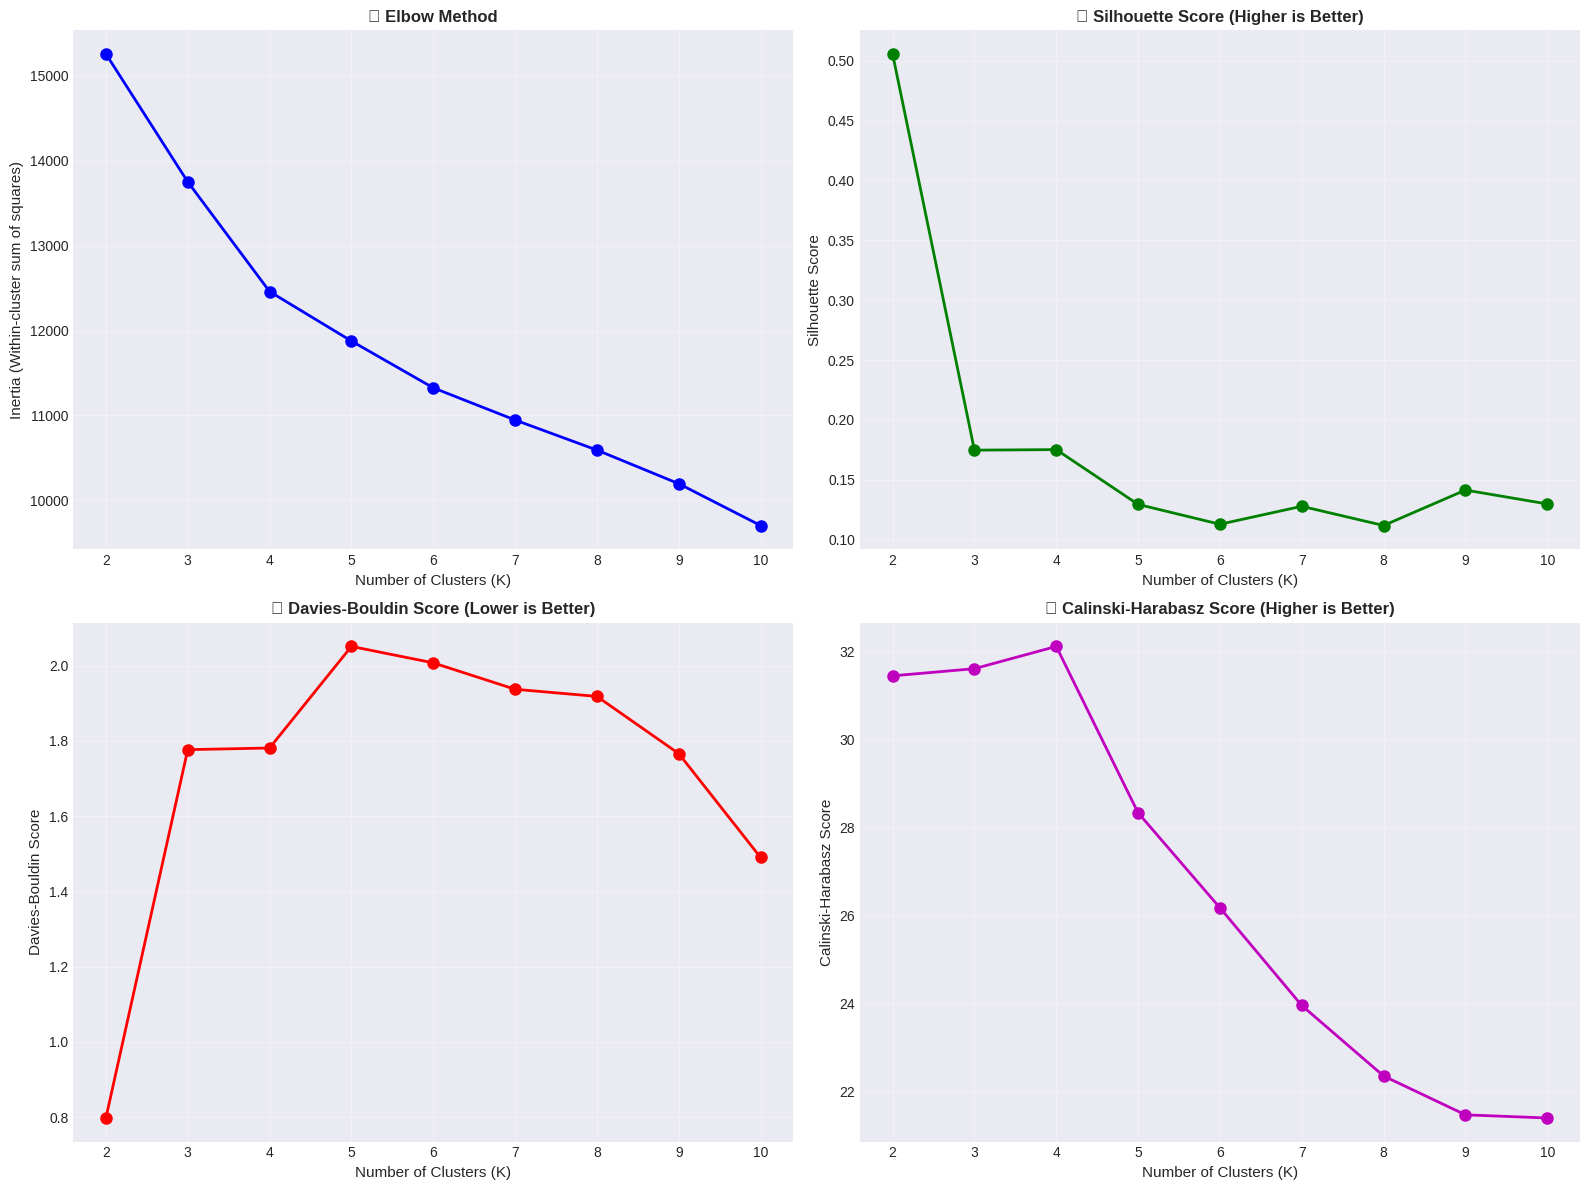

In [18]:
# Test different K values
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("\nTesting K values from 2 to 10...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(scaled_data, kmeans.labels_))
    calinski_harabasz_scores.append(calinski_harabasz_score(scaled_data, kmeans.labels_))
    
    print(f"   K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

# Visualization of metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Elbow curve
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=11)
axes[0, 0].set_title('📉 Elbow Method', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Silhouette score
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 1].set_title('📊 Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Davies-Bouldin score
axes[1, 0].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[1, 0].set_ylabel('Davies-Bouldin Score', fontsize=11)
axes[1, 0].set_title('📉 Davies-Bouldin Score (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Calinski-Harabasz score
axes[1, 1].plot(k_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=11)
axes[1, 1].set_title('📈 Calinski-Harabasz Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()

# Determine optimal K
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]
optimal_k_ch = k_range[np.argmax(calinski_harabasz_scores)]

print(f"\n🎯 OPTIMAL K RECOMMENDATIONS:")
print(f"   • Silhouette Score suggests: K = {optimal_k_silhouette}")
print(f"   • Davies-Bouldin Score suggests: K = {optimal_k_db}")
print(f"   • Calinski-Harabasz Score suggests: K = {optimal_k_ch}")

# Use the most common suggestion or default to silhouette
optimal_k = optimal_k_silhouette
print(f"\n✅ Selected optimal K = {optimal_k}")

# SECTION 3: K-MEANS CLUSTERING

In [19]:
# Apply K-Means with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_data)

# Get Algeria's cluster
algeria_cluster = kmeans_labels[algeria_idx]
print(f"\n🇩🇿 Algeria is in Cluster {algeria_cluster}")

# Cluster analysis
print(f"\n📊 CLUSTER DISTRIBUTION:")
for i in range(optimal_k):
    cluster_countries = countries[kmeans_labels == i].tolist()
    print(f"\n   Cluster {i}: {len(cluster_countries)} countries")
    if i == algeria_cluster:
        print(f"   >>> 🇩🇿 ALGERIA'S CLUSTER <<<")
    print(f"   Countries: {', '.join(cluster_countries[:10])}")
    if len(cluster_countries) > 10:
        print(f"   ... and {len(cluster_countries) - 10} more")

# Countries in Algeria's cluster
algeria_cluster_countries = countries[kmeans_labels == algeria_cluster].tolist()
print(f"\n🌍 COUNTRIES IN ALGERIA'S CLUSTER (Cluster {algeria_cluster}):")
print(f"   Total: {len(algeria_cluster_countries)} countries")
for idx, country in enumerate(algeria_cluster_countries, 1):
    marker = "🇩🇿" if country == "Algeria" else "  "
    print(f"   {marker} {idx}. {country}")


🇩🇿 Algeria is in Cluster 0

📊 CLUSTER DISTRIBUTION:

   Cluster 0: 257 countries
   >>> 🇩🇿 ALGERIA'S CLUSTER <<<
   Countries: Afghanistan, Albania, Algeria, American Samoa, Andorra, Angola, Antigua and Barbuda, Arab World, Argentina, Armenia
   ... and 247 more

   Cluster 1: 6 countries
   Countries: China, East Asia & Pacific, Europe & Central Asia, North America, United States, Upper middle income

🌍 COUNTRIES IN ALGERIA'S CLUSTER (Cluster 0):
   Total: 257 countries
      1. Afghanistan
      2. Albania
   🇩🇿 3. Algeria
      4. American Samoa
      5. Andorra
      6. Angola
      7. Antigua and Barbuda
      8. Arab World
      9. Argentina
      10. Armenia
      11. Aruba
      12. Australia
      13. Austria
      14. Azerbaijan
      15. Bahamas, The
      16. Bahrain
      17. Bangladesh
      18. Barbados
      19. Belarus
      20. Belgium
      21. Belize
      22. Benin
      23. Bermuda
      24. Bhutan
      25. Bolivia
      26. Bosnia and Herzegovina
      27. Bots

# SECTION 4: PCA VISUALIZATION OF K-MEANS


📊 PCA Explained Variance:
   PC1: 14.32%
   PC2: 13.84%
   Total: 28.16%


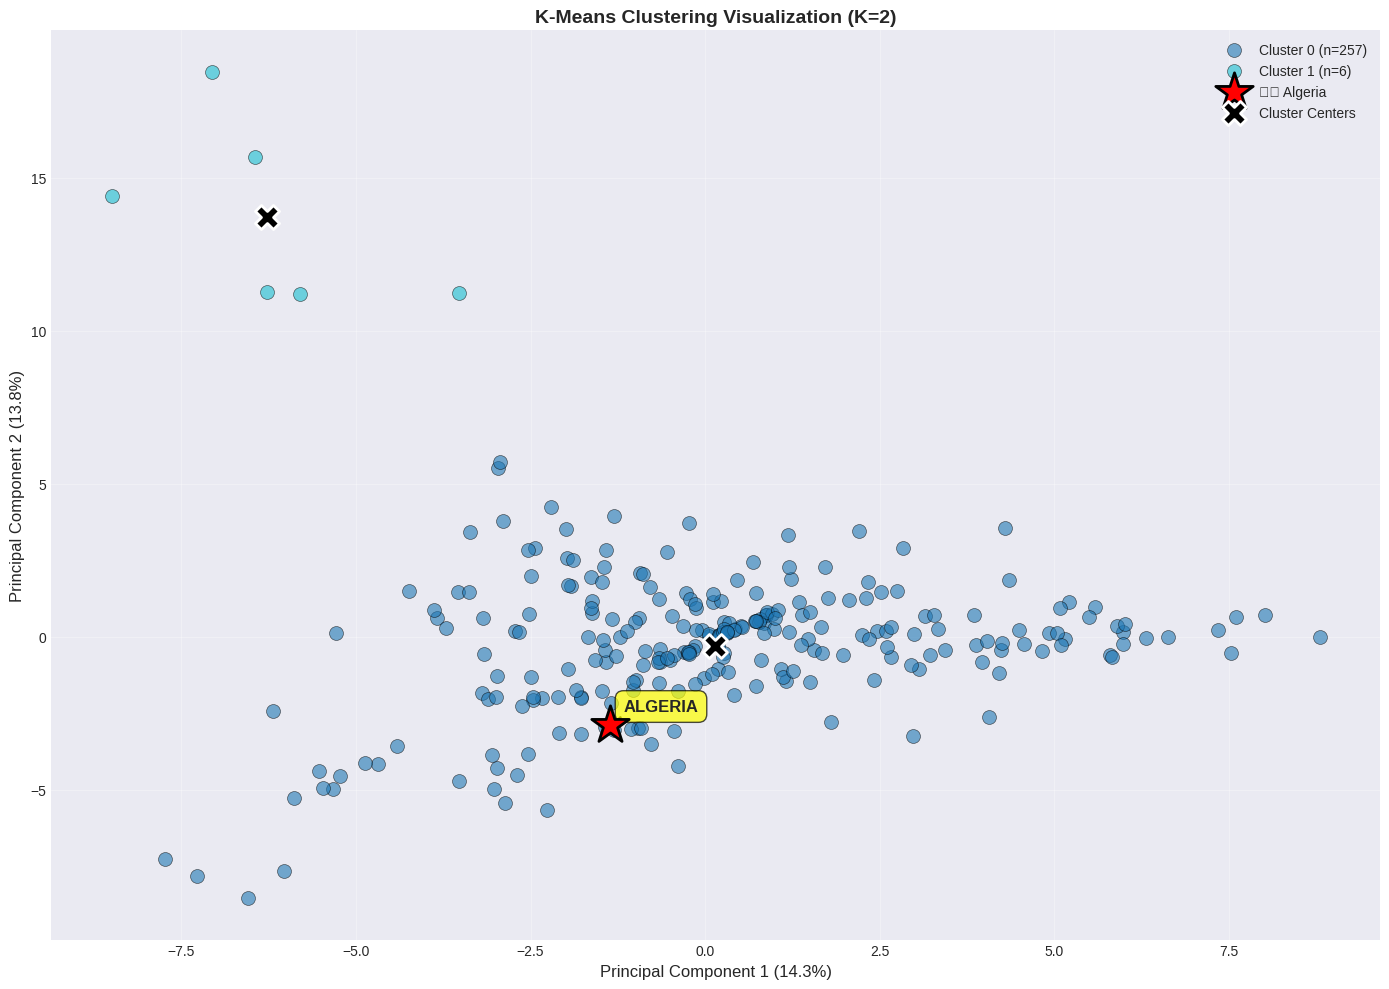

In [20]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(scaled_data)

print(f"\n📊 PCA Explained Variance:")
print(f"   PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"   PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"   Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Create visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Plot each cluster
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    cluster_mask = kmeans_labels == i
    ax.scatter(pca_data[cluster_mask, 0], 
              pca_data[cluster_mask, 1],
              c=[colors[i]], 
              label=f'Cluster {i} (n={cluster_mask.sum()})',
              alpha=0.6, 
              s=100,
              edgecolors='black',
              linewidth=0.5)

# Highlight Algeria
algeria_pca = pca_data[algeria_idx]
ax.scatter(algeria_pca[0], algeria_pca[1], 
          c='red', 
          marker='*', 
          s=800, 
          edgecolors='black', 
          linewidth=2,
          label='🇩🇿 Algeria',
          zorder=5)

# Add Algeria label
ax.annotate('ALGERIA', 
           xy=(algeria_pca[0], algeria_pca[1]),
           xytext=(10, 10),
           textcoords='offset points',
           fontsize=12,
           fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=2))

# Plot cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1],
          c='black',
          marker='X',
          s=300,
          edgecolors='white',
          linewidth=2,
          label='Cluster Centers',
          zorder=4)

ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax.set_title(f'K-Means Clustering Visualization (K={optimal_k})', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()

# SECTION 5: CLUSTER PROFILING

In [21]:
# Add cluster labels to dataframe
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = kmeans_labels

# Calculate cluster statistics for key indicators
key_indicators = [
    'Gross national income per capita, Atlas method_$_2024',
    'Gross domestic product_% growth_2024',
    'Structure_Value_Industry_% of GDP_2024',
    'Structure_Value_Services_% of GDP_2024',
    'Unemployment_Unemployment, male (% of male labor force) (modeled ILO estimate)_2021'
]

available_indicators = [col for col in key_indicators if col in df.columns]

print(f"\n📊 CLUSTER PROFILES (Key Indicators):")
for i in range(optimal_k):
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == i]
    print(f"\n{'='*60}")
    print(f"CLUSTER {i} - {len(cluster_data)} countries")
    if i == algeria_cluster:
        print(">>> 🇩🇿 ALGERIA'S CLUSTER <<<")
    print(f"{'='*60}")
    
    for indicator in available_indicators:
        values = cluster_data[indicator].dropna()
        if len(values) > 0:
            print(f"\n   {indicator[:60]}:")
            print(f"      Mean: {values.mean():.2f}")
            print(f"      Median: {values.median():.2f}")
            print(f"      Std: {values.std():.2f}")
            print(f"      Min: {values.min():.2f}, Max: {values.max():.2f}")



📊 CLUSTER PROFILES (Key Indicators):

CLUSTER 0 - 257 countries
>>> 🇩🇿 ALGERIA'S CLUSTER <<<

   Gross national income per capita, Atlas method_$_2024:
      Mean: 16080.81
      Median: 7990.00
      Std: 21288.64
      Min: 190.00, Max: 140280.00

   Gross domestic product_% growth_2024:
      Mean: 3.16
      Median: 3.24
      Std: 4.06
      Min: -26.56, Max: 43.37

   Structure_Value_Industry_% of GDP_2024:
      Mean: 24.81
      Median: 24.00
      Std: 10.63
      Min: 2.10, Max: 74.30

   Structure_Value_Services_% of GDP_2024:
      Mean: 57.21
      Median: 57.50
      Std: 11.42
      Min: 15.30, Max: 95.10

   Unemployment_Unemployment, male (% of male labor force) (mod:
      Mean: 7.19
      Median: 6.11
      Std: 4.81
      Min: 0.08, Max: 32.88

CLUSTER 1 - 6 countries

   Gross national income per capita, Atlas method_$_2024:
      Mean: 38685.53
      Median: 21760.69
      Std: 34244.74
      Min: 10880.41, Max: 83660.00

   Gross domestic product_% growth_2024:


# SECTION 6: DBSCAN CLUSTERING

In [22]:
# Test different epsilon values
print("\n🔍 Testing DBSCAN with different epsilon values...")
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
dbscan_results = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(scaled_data)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    dbscan_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'labels': dbscan_labels
    })
    
    print(f"   eps={eps}: {n_clusters} clusters, {n_noise} noise points")

# Select best epsilon (most clusters with reasonable noise)
best_dbscan = min(dbscan_results, key=lambda x: abs(x['n_clusters'] - optimal_k) if x['n_clusters'] > 0 else 999)
best_eps = best_dbscan['eps']
dbscan_labels = best_dbscan['labels']

print(f"\n✅ Selected epsilon = {best_eps}")
print(f"   Clusters found: {best_dbscan['n_clusters']}")
print(f"   Noise points: {best_dbscan['n_noise']}")

# Get Algeria's DBSCAN cluster
algeria_dbscan_cluster = dbscan_labels[algeria_idx]
if algeria_dbscan_cluster == -1:
    print(f"\n⚠️ Algeria classified as NOISE (outlier)")
else:
    print(f"\n🇩🇿 Algeria is in DBSCAN Cluster {algeria_dbscan_cluster}")

# DBSCAN cluster distribution
print(f"\n📊 DBSCAN CLUSTER DISTRIBUTION:")
unique_labels = set(dbscan_labels)
for label in sorted(unique_labels):
    if label == -1:
        cluster_countries = countries[dbscan_labels == label].tolist()
        print(f"\n   NOISE (Outliers): {len(cluster_countries)} countries")
        print(f"   Countries: {', '.join(cluster_countries[:10])}")
        if len(cluster_countries) > 10:
            print(f"   ... and {len(cluster_countries) - 10} more")
    else:
        cluster_countries = countries[dbscan_labels == label].tolist()
        print(f"\n   Cluster {label}: {len(cluster_countries)} countries")
        if label == algeria_dbscan_cluster:
            print(f"   >>> 🇩🇿 ALGERIA'S CLUSTER <<<")
        print(f"   Countries: {', '.join(cluster_countries[:10])}")
        if len(cluster_countries) > 10:
            print(f"   ... and {len(cluster_countries) - 10} more")



🔍 Testing DBSCAN with different epsilon values...
   eps=0.5: 1 clusters, 244 noise points
   eps=1.0: 1 clusters, 238 noise points
   eps=1.5: 1 clusters, 225 noise points
   eps=2.0: 1 clusters, 224 noise points
   eps=2.5: 1 clusters, 222 noise points
   eps=3.0: 1 clusters, 220 noise points

✅ Selected epsilon = 0.5
   Clusters found: 1
   Noise points: 244

⚠️ Algeria classified as NOISE (outlier)

📊 DBSCAN CLUSTER DISTRIBUTION:

   NOISE (Outliers): 244 countries
   Countries: Afghanistan, Albania, Algeria, American Samoa, Andorra, Angola, Antigua and Barbuda, Arab World, Argentina, Armenia
   ... and 234 more

   Cluster 0: 19 countries
   Countries: British Virgin Islands, East Asia & Pacific (IDA & IBRD countries), East Asia & Pacific (excluding high income), Fragile and conflict affected situations, Gibraltar, Heavily indebted poor countries (HIPC), IDA & IBRD total, IDA only, IDA total, Late-demographic dividend
   ... and 9 more


# SECTION 7: DBSCAN VISUALIZATION

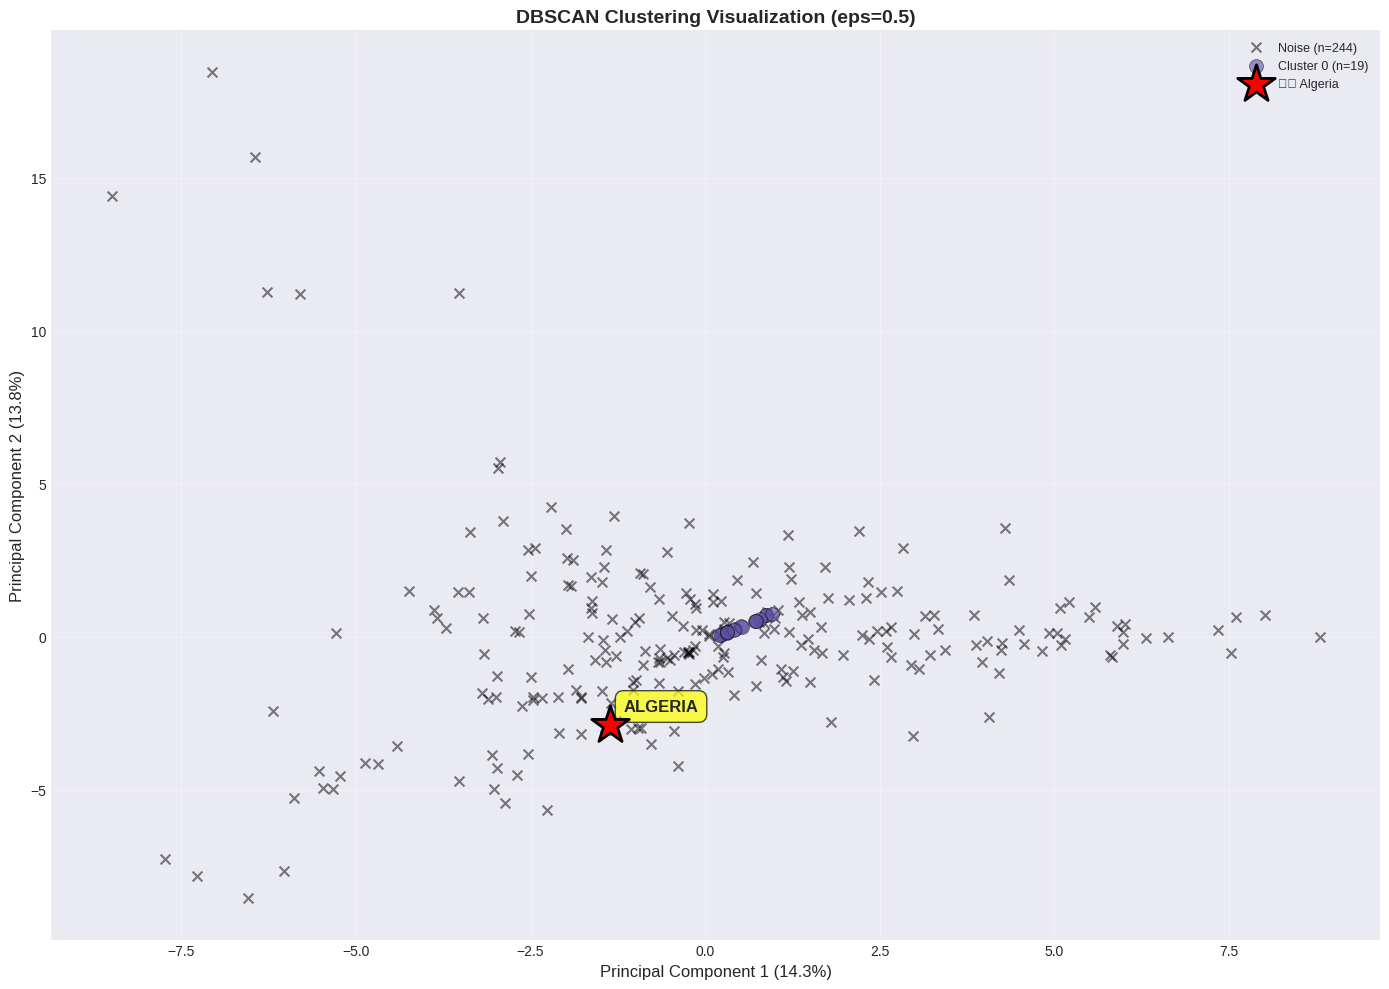

In [23]:
fig, ax = plt.subplots(figsize=(14, 10))

# Plot clusters
unique_labels = set(dbscan_labels)
colors_dbscan = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(sorted(unique_labels), colors_dbscan):
    if label == -1:
        # Noise points in black
        cluster_mask = dbscan_labels == label
        ax.scatter(pca_data[cluster_mask, 0],
                  pca_data[cluster_mask, 1],
                  c='black',
                  marker='x',
                  s=50,
                  alpha=0.5,
                  label=f'Noise (n={cluster_mask.sum()})')
    else:
        cluster_mask = dbscan_labels == label
        ax.scatter(pca_data[cluster_mask, 0],
                  pca_data[cluster_mask, 1],
                  c=[color],
                  label=f'Cluster {label} (n={cluster_mask.sum()})',
                  alpha=0.6,
                  s=100,
                  edgecolors='black',
                  linewidth=0.5)

# Highlight Algeria
ax.scatter(algeria_pca[0], algeria_pca[1],
          c='red',
          marker='*',
          s=800,
          edgecolors='black',
          linewidth=2,
          label='🇩🇿 Algeria',
          zorder=5)

# Add Algeria label
ax.annotate('ALGERIA',
           xy=(algeria_pca[0], algeria_pca[1]),
           xytext=(10, 10),
           textcoords='offset points',
           fontsize=12,
           fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=2))

ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax.set_title(f'DBSCAN Clustering Visualization (eps={best_eps})', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()

# SECTION 8: COMPARISON - K-MEANS VS DBSCAN

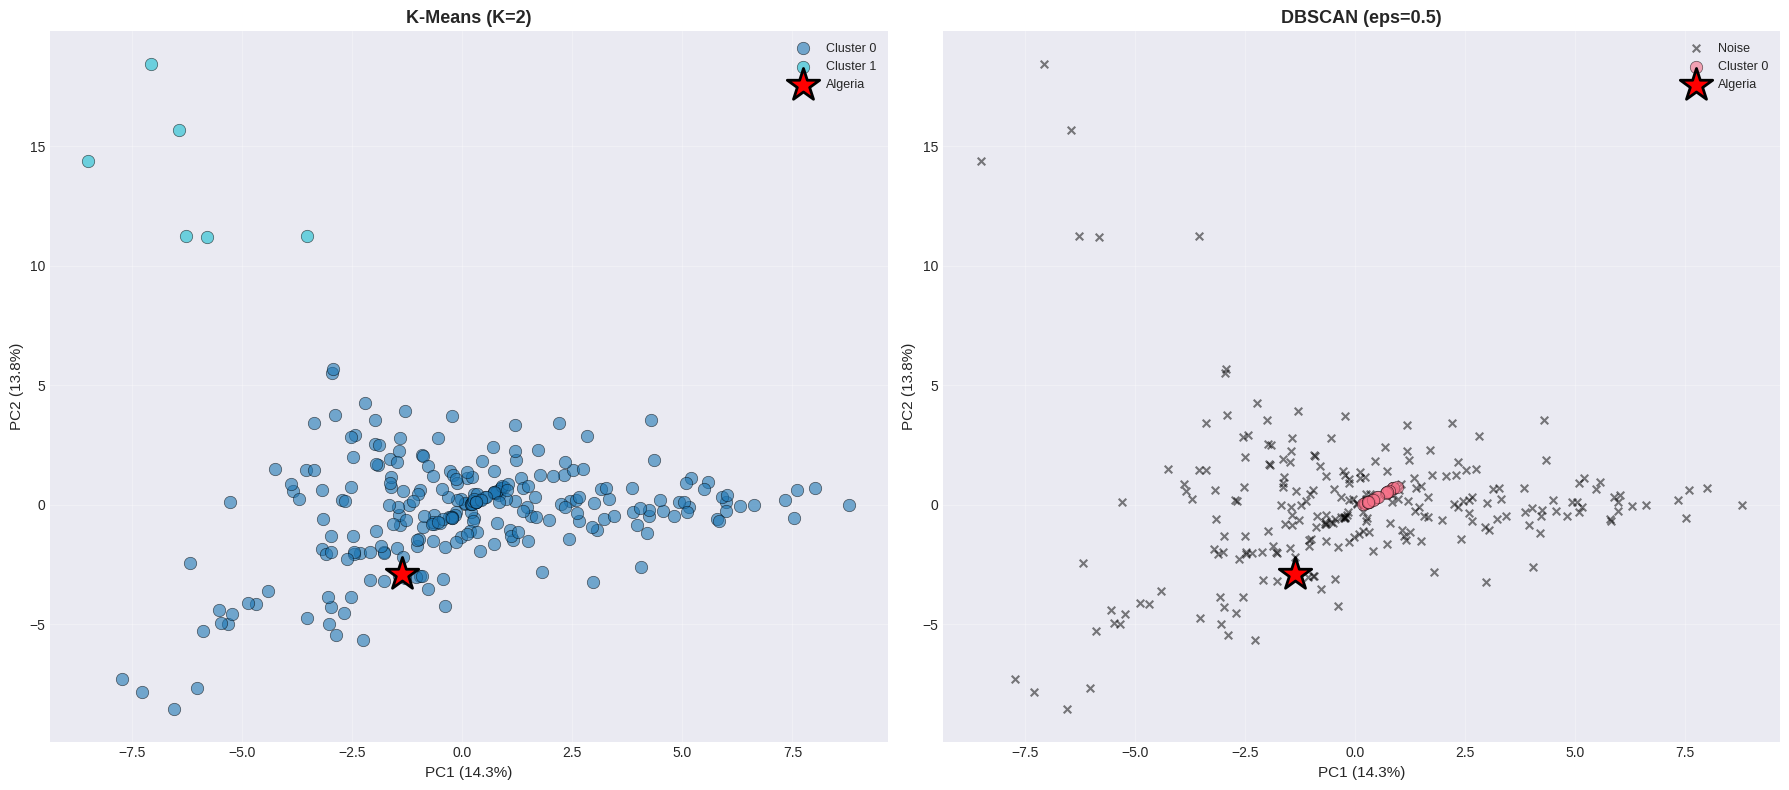

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# K-Means
for i in range(optimal_k):
    cluster_mask = kmeans_labels == i
    ax1.scatter(pca_data[cluster_mask, 0],
               pca_data[cluster_mask, 1],
               c=[colors[i]],
               label=f'Cluster {i}',
               alpha=0.6,
               s=80,
               edgecolors='black',
               linewidth=0.5)
ax1.scatter(algeria_pca[0], algeria_pca[1],
           c='red', marker='*', s=600, edgecolors='black', linewidth=2,
           label='Algeria', zorder=5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax1.set_title(f'K-Means (K={optimal_k})', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# DBSCAN
for label in sorted(unique_labels):
    if label == -1:
        cluster_mask = dbscan_labels == label
        ax2.scatter(pca_data[cluster_mask, 0],
                   pca_data[cluster_mask, 1],
                   c='black', marker='x', s=30, alpha=0.5, label='Noise')
    else:
        cluster_mask = dbscan_labels == label
        ax2.scatter(pca_data[cluster_mask, 0],
                   pca_data[cluster_mask, 1],
                   label=f'Cluster {label}',
                   alpha=0.6,
                   s=80,
                   edgecolors='black',
                   linewidth=0.5)
ax2.scatter(algeria_pca[0], algeria_pca[1],
           c='red', marker='*', s=600, edgecolors='black', linewidth=2,
           label='Algeria', zorder=5)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax2.set_title(f'DBSCAN (eps={best_eps})', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()